## Generating PAH emission spectra
This notebook shows an example of how to generate an emission spectrum from an arbitrary radiation field, $u_\lambda$, for grains in the single-photon absorption limit using the method described in Richie & Hensley (2025).

This method treats each photon absorption event independently by calculating calculating an eigenvector, $\tilde{p}_\lambda$, for each grain at every absorbed photon wavelength, $\lambda_\mathrm{abs}$, and scaling them to the input radiation field.

In [1]:
# imports
from astropy.constants import c, h
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.integrate import trapezoid
import seaborn as sns
import sys

# local imports
sys.path.insert(0, "./routines/")
from pah_spec_routines import calc_cabs, calc_pah_energy, calc_pah_cooling, calc_eigenvector, calc_normalization

# don't include in final version
sys.path.insert(0, "/Users/helenarichie/GitHub/my_scripts/")
import hconfig

In this example, we'll generate 6 eigenvectors for photons ranging from $0.1-25~\mu m$ in wavelength for a single 5 $\AA$ ionized grain. Note that a set of eigenvectors spanning the absorbed photon wavelength range with a spacing of $\Delta\lambda / \lambda\sim0.01$ is needed to create a full integrated spectrum.

In [2]:
# define the grain radius
grain_radius = 5.0 * u.AA

# define the eigenvector wavelengths
photon_wavelengths = [0.1, 0.3, 0.5, 1, 5, 25] * u.um

# define emission wavelengths
emission_wavelengths = np.logspace(np.log10(0.1), np.log10(3e4), 10000) * u.um

Now, we'll read in a data file that defines the radiation field, $u_\lambda(\lambda)$, from Mathis et al. 1983.

In [3]:
# read in radiation field data
df_ISRF = pd.read_csv("./data/isrf.out", sep="\s+")
wav_isrf = df_ISRF["(wav)"].to_numpy() * u.um
u_lambda = df_ISRF["(spec)"].to_numpy() * (u.erg / u.cm**3) / wav_isrf.to(u.cm)

Now, we'll define the grain's absorption cross-section as a function of our emission wavelengths using the method described in Draine et al. (2021) implemented in the `calc_cabs()` function.

In [4]:
print(calc_cabs.__doc__)  # print out the function's docstring
# read in cross-section data
cabs_ion_arr, cabs_neu_arr = calc_cabs(emission_wavelengths, [grain_radius.value] * u.AA)
cabs_ion_arr, cabs_neu_arr = cabs_ion_arr[0], cabs_neu_arr[0]

Calculate the absorption cross-section, C_abs, for input grain sizes and wavelengths based on method from
    Draine et al. (2021).

    Parameters
    ----------
    wavelength_arr : astropy.units.Quantity (array_like)
        Array of wavelengths to calculate C_abs for
    radius_arr : astropy.units.Quantity (array_like)
        Array of dust grain radii to calculate C_abs for

    Returns
    -------
    cabs_ion_out : astropy.units.Quantity (array_like)
        Array with C_abs values for ionized grains (in u.cm ** 2)
    cabs_neu_out : astropy.units.Quantity (array_like)
        Array with C_abs values for neutral grains (in u.cm ** 2)

    Raises
    ------
    AttributeError
        If the input is not an astropy.units.Quantity object
    TypeError
        If the astropy.units.Quantity object has incorrect units (or optionally is not array-like)
    FileNotFoundError
        If the directory data_path does not exist
    


Now, we'll loop over our photon wavelengths to generate the eigenvectors, and scale them to the ISRF. The general steps are:
1. Calculate the grain's energy-temperature relationship using the method described in Draine & Li (2001), which is implemented in `calc_pah_energy()`.
2. Calculate the time evolution of the grain's temperature, $T(t)$, as it radiatively cools back down to its ground state following the photon absorption using the `calc_pah_cooling()` function.
3. Calculate the eigenvectors for each photon wavelength, $\tilde{p}_\lambda$, which are defined as
\begin{equation}
\tilde{p}_\lambda = \sum_t 4\pi B_\lambda(T(t)) C_\mathrm{abs}(\lambda),
\end{equation}
where $B_\lambda$ is the Planck function using the `calc_eigenvectors()` function.
4. Determine the scaling for the using the `calc_normalization()` function, which calculates
\begin{equation}
\text{norm} = \frac{\int_{\lambda_\mathrm{abs}}^{\lambda_\mathrm{abs}+d\lambda}cu_\lambda(\lambda) C_\mathrm{abs}(\lambda)d\lambda}{\int \tilde{p}_{\lambda_\mathrm{em}}(\lambda_\mathrm{abs})d\lambda},
\end{equation}
which ensures that the energy absorbed by the grain from the radiation field is equal to the energy radiated by the grain.
5. Scale the eigenvector by the normalization to get $p_\lambda(\lambda_\mathrm{abs})=\text{norm}\times\tilde{p}_\lambda(\lambda_\mathrm{abs})$.
6. Sum the $p_\lambda(\lambda_\mathrm{abs})$ over all $\lambda_\mathrm{abs}$ to get the integrated spectrum. 

Calculate PAH vibrational energy as a function of temperature according to Eq. 33 of Draine & Li (2001).

    Parameters
    ----------
    grain_radius : astropy.units.Quantity (float)
        The PAH effective radius
    temp_arr : astropy.units.Quantity (array-like)
        Array of temperature to calculate energies for

    Returns
    -------
    energies : astropy.units.Quantity (array_like)
        Resulting PAH energy array (in u.ergs)

    Raises
    ------
    AttributeError
        If the input is not an astropy.units.Quantity object
    TypeError
        If the astropy.units.Quantity object has incorrect units (or optionally is not array-like)
    


/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'Temperature [K]')

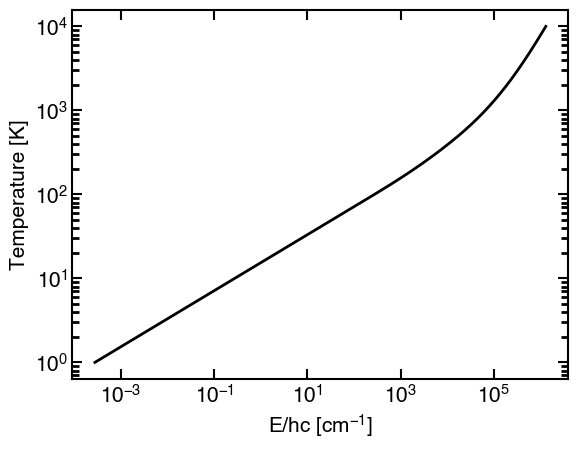

In [5]:
# Step 1:
print(calc_pah_energy.__doc__)

temp_arr = np.linspace(1, 1e4, 1000) * u.K
energy_arr = calc_pah_energy(grain_radius, temp_arr)

plt.loglog(energy_arr / (h.cgs * c.cgs), temp_arr, c="k")
plt.xlabel(r"$E/hc~[cm^{-1}]$")
plt.ylabel("Temperature [K]")

In [6]:
print(calc_pah_cooling.__doc__)
print(calc_eigenvector.__doc__)

eigenvectors = np.zeros((len(photon_wavelengths), len(emission_wavelengths)))
times, temperatures = [], []

for i, lambda_abs in enumerate(photon_wavelengths):
    # Step 2:
    dt_arr, time_arr, temp_arr_t = calc_pah_cooling(
        lambda_abs, grain_radius, emission_wavelengths, cabs_ion_arr, temp_arr, energy_arr
    )
    times.append(time_arr)
    temperatures.append(temp_arr_t)
    temp_arr_t = temp_arr_t[0:-1]
    dt_norm_arr = dt_arr / np.sum(dt_arr)

    # Step 3:
    eigenvectors[i] = calc_eigenvector(emission_wavelengths, dt_norm_arr, temp_arr_t, cabs_ion_arr)

Calculate the temperature evolution of a PAH following a single-photon absorption.

    Parameters
    ----------
    lambda_abs : astropy.units.Quantity (float)
        Wavelength of absorbed photon
    grain_radius : astropy.units.Quantity (float)
        Dust grain radius
    wavelength_arr : astropy.units.Quantity (array_like)
        Emission wavelengths to integrate over
    c_abs_arr : astropy.units.Quantity (array_like)
        Array of length len(wavelength_arr) with C_abs values for a grain of size grain_radius
    temp_arr : astropy.units.Quantity (array_like)
        Array of temperatures corresponding to PAH vibrational energies for a grain of size grain_radius
    energy_arr : astropy.units.Quantity (array_like)
        Array of PAH vibrational energies as a function of temperature for a grain of size grain_radius

    Returns
    -------
    dt_arr_out : astropy.units.Quantity (array_like)
        Array of time-steps used to solve for T(t) (in u.s)
    time_arr_out : ast

/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Final temperature of 5.00 K at time 2.45e+06 s
Photon wavelength: 0.30 um, initial temperature: 685.37 K
Final temperature of 5.00 K at time 2.45e+06 s
Photon wavelength: 0.50 um, initial temperature: 531.63 K
Final temperature of 5.00 K at time 2.45e+06 s
Photon wavelength: 1.00 um, initial temperature: 387.46 K
Final temperature of 5.00 K at time 2.44e+06 s
Photon wavelength: 5.00 um, initial temperature: 201.53 K
Final temperature of 5.00 K at time 2.45e+06 s
Photon wavelength: 25.00 um, initial temperature: 113.26 K
Final temperature of 5.00 K at time 2.45e+06 s


Text(0, 0.5, 'Temperature [K]')

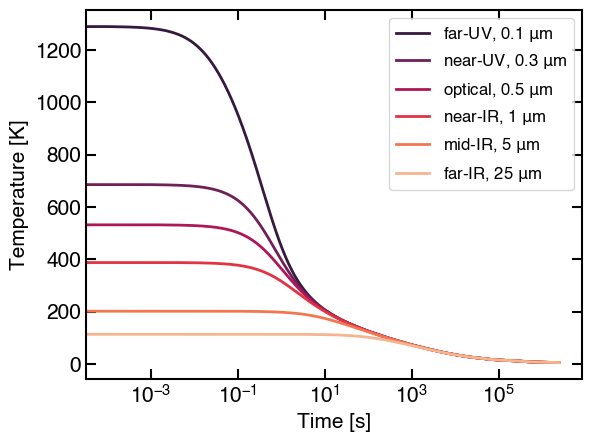

In [7]:
colors = sns.color_palette("rocket", n_colors=len(photon_wavelengths))
labels = [
    r"far-UV, $0.1~\mu m$",
    r"near-UV, $0.3~\mu m$",
    r"optical, $0.5~\mu m$",
    r"near-IR, $1~\mu m$",
    r"mid-IR, $5~\mu m$",
    r"far-IR, $25~\mu m$",
]

for i, lambda_abs in enumerate(photon_wavelengths):
    plt.semilogx(times[i], temperatures[i], color=colors[i], label=labels[i])

plt.legend(fontsize=12)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")

Text(0.5, 1.0, 'Eigenvectors')

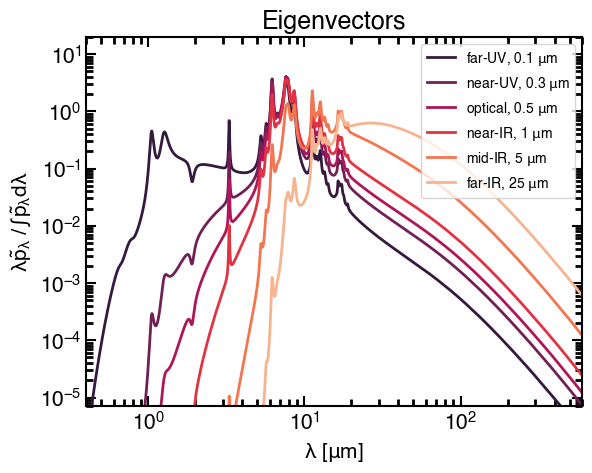

In [8]:
for i, lambda_abs in enumerate(photon_wavelengths):
    plt.loglog(
        emission_wavelengths,
        eigenvectors[i] * emission_wavelengths.to(u.cm) / trapezoid(eigenvectors[i], x=emission_wavelengths.to(u.cm)),
        color=colors[i],
        label=labels[i],
    )
plt.xlim(0.4, 600)
plt.ylim(7e-6, 20)
plt.legend(fontsize=10, loc="upper right")
plt.ylabel(r"$\lambda \tilde{p}_\lambda$ / $\int \tilde{p}_\lambda d\lambda$")
plt.xlabel(r"$\lambda~[\mu m]$")
plt.title("Eigenvectors")

In [9]:
# Step 4:
print(calc_normalization.__doc__)
p_lambda = np.zeros((len(photon_wavelengths), len(emission_wavelengths)))

for i, lambda_abs in enumerate(photon_wavelengths):
    num, denom = calc_normalization(
        lambda_abs, 0.01, emission_wavelengths, cabs_ion_arr, wav_isrf, u_lambda, eigenvectors[i] * u.erg / (u.cm * u.s)
    )
    # Step 5:
    p_lambda[i] = (num / denom) * eigenvectors[i]

Calculate the energy conservation normalization to scale an eigenvector to an input radiation field.

    Parameters
    ----------
    lambda_abs : astropy.units.Quantity (float)
        Wavelength of absorbed photon
    mrf_width : float
        Width of the "monochromatic" radiation field, defined as a percentage of lambda_abs
    wavelength_arr : astropy.units.Quantity (array_like)
        Array of emission wavelengths
    c_abs_arr : astropy.units.Quantity (array_like)
        Array of length len(wavelength_arr) with C_abs values for a given grain
    wavelengths_u : astropy.units.Quantity (array_like)
        Wavelength array for the radiation field u_lambda
    u_lambda : astropy.units.Quantity (array_like)
        Array of length len(wavelengths_u) with the radiation field
    p_lambda : astropy.units.Quantity (array_like)
        Eigenvector array of length len(wavelength_arr) for a given grain and lambda_abs

    Returns
    -------
    normalization : float
        Incident 

Again, note that this example does not use enough eigenvectors to reproduce the full integrated spectrum, but we could plot the total spectrum from the $p_\lambda$ array like this:

Text(0.5, 1.0, 'Integrated Spectrum')

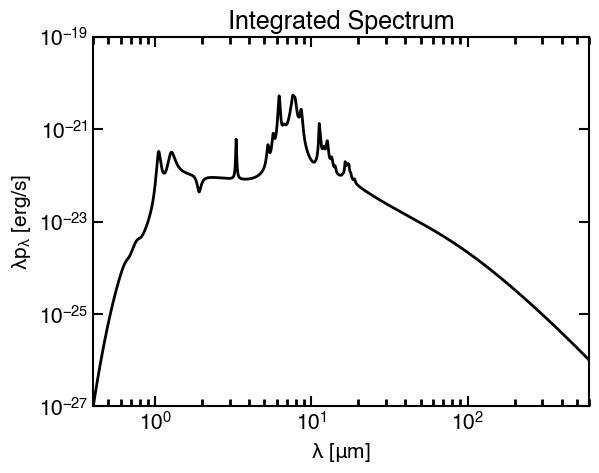

In [10]:
plt.loglog(emission_wavelengths, np.sum(p_lambda, axis=0) * emission_wavelengths.to(u.cm), color="k")
plt.xlim(0.4, 600)
plt.ylim(1e-27, 1e-19)
plt.ylabel(r"$\lambda p_\lambda$ [erg/s]")
plt.xlabel(r"$\lambda~[\mu m]$")
plt.title("Integrated Spectrum")